In [1]:
# Cell 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- IMPORT SHARED UTILS ---
%load_ext autoreload
%autoreload 2
from db_utils import get_engine

plt.style.use('seaborn-v0_8')

# --- DATA FETCHING ---
engine = get_engine()

# Query: Calculate delays per state
query = """
SELECT 
    c.customer_state,
    COUNT(o.order_id) as total_orders,
    SUM(CASE 
        WHEN o.order_delivered_customer_date::timestamp > o.order_estimated_delivery_date::timestamp 
        THEN 1 ELSE 0 END) as delayed_orders,
    -- ФІКС: Явно приводимо до timestamp перед відніманням
    AVG(EXTRACT(DAY FROM (o.order_delivered_customer_date::timestamp - o.order_purchase_timestamp::timestamp))) as avg_delivery_days
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_state
HAVING COUNT(o.order_id) > 100 -- Filter out insignificant states
ORDER BY delayed_orders DESC;
"""

df_logistics = pd.read_sql(query, engine)
df_logistics.head()

,customer_state,total_orders,delayed_orders,avg_delivery_days
0,SP,40501,2387,8.298094
1,RJ,12350,1664,14.848583
2,MG,11354,637,11.542188
3,BA,3256,457,18.866400
4,RS,5345,382,14.819237


In [2]:
print("🔄 Calculating Delay Rates...")
df_logistics['delay_rate'] = (df_logistics['delayed_orders'] / df_logistics['total_orders']) * 100
df_logistics = df_logistics.sort_values('delay_rate', ascending=False)
df_logistics.head()

🔄 Calculating Delay Rates...


,customer_state,total_orders,delayed_orders,avg_delivery_days,delay_rate
14,AL,397,95,24.040302,23.929471
12,MA,717,141,21.117155,19.665272
16,PI,476,76,18.993697,15.966387
8,CE,1279,196,20.817826,15.324472
20,SE,335,51,21.029851,15.223881


📊 Generating Bar Chart...


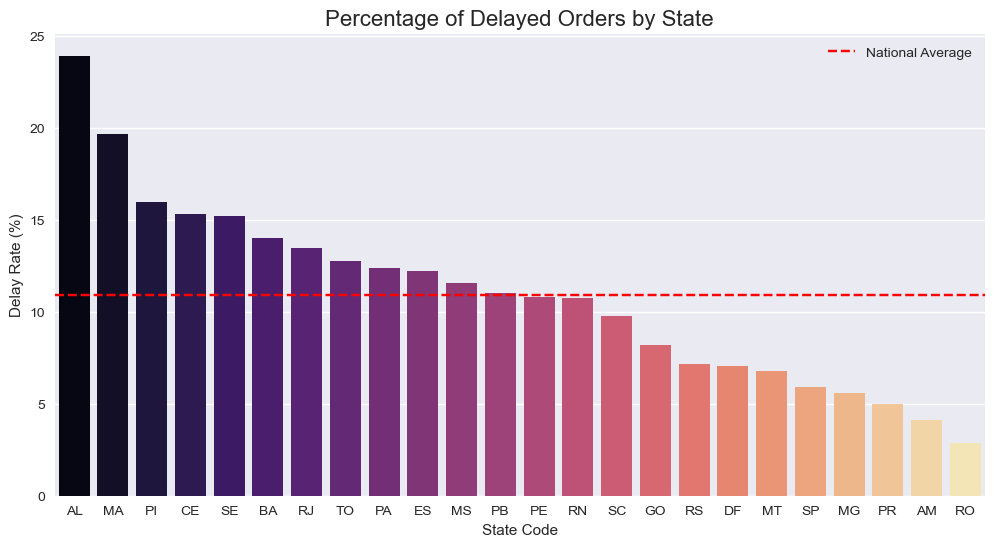

In [3]:
print("📊 Generating Bar Chart...")
plt.figure(figsize=(12, 6))

# Bar chart for Delay Rate
sns.barplot(
    x='customer_state', 
    y='delay_rate', 
    data=df_logistics, 
    palette='magma', 
    hue='customer_state', 
    legend=False
)

plt.axhline(y=df_logistics['delay_rate'].mean(), color='r', linestyle='--', label='National Average')
plt.title('Percentage of Delayed Orders by State', fontsize=16)
plt.ylabel('Delay Rate (%)')
plt.xlabel('State Code')
plt.legend()

plt.show()

In [4]:
# --- CONCLUSION ---
top_delay_state = df_logistics.iloc[0]

print(">>> LOGISTICS ANALYSIS COMPLETED")
print(f"Key Finding: State '{top_delay_state['customer_state']}' has the highest delay rate ({top_delay_state['delay_rate']:.1f}%).")
print("NOTE: Regional infrastructure recommendations are available in README.md")

>>> LOGISTICS ANALYSIS COMPLETED
Key Finding: State 'AL' has the highest delay rate (23.9%).
NOTE: Regional infrastructure recommendations are available in README.md
